# Sort spikes and make rasters

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'
N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

if 'pakhi' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'

if 'pouli' in socket.gethostname():
    os.environ["KILOSORT3_PATH"] = '/home/pouli/repos/Kilosort'

2022-07-17 08:14:10,475 root         INFO     Running on pakhi


In [2]:
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

from ceciestunepipe.pipeline import searchbout as sb

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-07-17 08:14:12,095 root         INFO     all modules loaded


### Session parameters and raw files

In [3]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [4]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-07-16',
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [5]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx'

In [6]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-07-17 08:14:12,726 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx', 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-07-16', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-07-16', 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/rig.json', 'kwd': '/scratch/

['0703_g0', '1426_g0']

In [9]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[1] # 
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [10]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/1426_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/1426_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0',
  'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-07-16/1426_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx/1426_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0',
  'tmp': '/scratch/earneodo/tmp/1426_g0',
  'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-07-16/1426_g0',
  'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/1426_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/1426_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-0

In [11]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0/1426_g0_imec0'}

In [12]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0/1426_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0/1426_g0_imec0/1426_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0/1426_g0_imec0/1426_g0_t0.imec0.ap.meta']}

In [13]:
files_pd = pd.DataFrame(sgl_files)

### load epoch files

In [14]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]


In [15]:
run_recordings

{'nidq': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f355470c2e0>,
 'lf_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f35945dcd30>,
 'ap_0': <ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor at 0x7f35945d6be0>}

### Sync signals
(starts in a process, will let know when done. The idea is that it can run while spike sorting, if its long)

In [16]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: sy.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

sync_p = Process(target=sy.sync_all, args=(all_syn_dict, sess_par['ref_stream']), 
                 kwargs={'force': False}
                )
sync_p.start()

2022-07-17 08:17:05,596 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2022-07-17 08:17:05,600 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/nidq_sync_dict.pkl
2022-07-17 08:17:05,615 ceciestunepipe.util.sglxsync INFO     getting syn patterns for lf_0
2022-07-17 08:17:05,616 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/lf_0_sync_dict.pkl
2022-07-17 08:17:05,642 ceciestunepipe.util.sglxsync INFO     getting syn patterns for ap_0
2022-07-17 08:17:05,643 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/ap_0_sync_dict.pkl
2022-07-17 08:17:05,663 ceciestunepipe.util.sglxsync INFO     getting syn patterns for wav
2022-07-17 08:17:05,664 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/deri

## The sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

###### view it raw

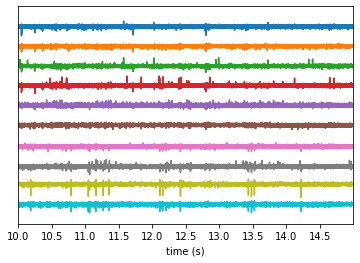

In [17]:
sw.plot_timeseries(run_recordings['ap_0'], channel_ids=range(40, 50), trange=[10,15])

###### filtered

In [18]:
# ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
# sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[10,15])

###### cmr

In [19]:
# ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
# sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

In [20]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/1426_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/1426_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-07-16/sglx/1426_g0',
 'kwik': '/scratch/earneodo/s_b1555_22/sglx/kwik/2022-07-16/1426_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-07-16/sglx/1426_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0',
 'tmp': '/scratch/earneodo/tmp/1426_g0',
 'msort': '/scratch/earneodo/s_b1555_22/sglx/msort/2022-07-16/1426_g0',
 'ksort': '/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/1426_g0/sort_0',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/sort_0'}

In [21]:
ss.__version__

'0.4.5'

In [22]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [23]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500}

##### manually enter ksort params

In [24]:
ks_params = {'minFR': 0.001,
             'minfr_goodchannels': 0.001}

#### run the spike sort

In [25]:
reload(ks)

<module 'ceciestunepipe.util.spike.kilosort' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py'>

In [26]:
exp_struct['folders']['ksort']

'/scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/1426_g0/sort_0'

In [27]:
## 
tmp_loc = os.path.join(exp_struct['folders']['ksort'])

sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle')
def do_sort():
    return ks.run_spikesort(run_recordings['ap_0'], logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, 
                     sorting_method='kilosort3', chunk_mb=8192, force_redo=False,
                     **ks_params)

sort_p = Process(target=do_sort)
sort_p.start()

2022-07-17 08:18:34,048 root         INFO     Grouping property: None
2022-07-17 08:18:34,080 root         INFO     sorting method: kilosort3
2022-07-17 08:18:34,081 root         INFO     Will set visible gpu devices 1
2022-07-17 08:18:34,083 root         INFO     Sorting tmp dir /scratch/earneodo/s_b1555_22/sglx/ksort/2022-07-16/1426_g0/sort_0/tmp_ks3
2022-07-17 08:18:34,084 root         INFO     Previous sort not found, sorting
Writing to binary .dat file: 100%|##########| 63/63 [33:57<00:00, 32.33s/it]  


### interlude: process the segmented, curated bouts

In [28]:
hparams, bout_pd = sb.load_bouts(sess_par['bird'], sess_par['sess'], '', 
                                 derived_folder = 'bouts_sglx', bout_file_key='bout_curated_file')

In [29]:
### filter_by epoch
logger.info('filtering only good bouts from this epoch {}'.format(sess_par['epoch']))

## drop bouts that are not from the session OR that are not bout_check

drop_condition = (~bout_pd['file'].str.contains(sess_par['epoch'])) | (bout_pd['bout_check']==False)

bout_pd.drop(bout_pd[drop_condition].index, inplace=True)
bout_pd.reset_index(drop=True, inplace=True)

2022-07-17 10:36:21,167 root         INFO     filtering only good bouts from this epoch 1426_g0


In [30]:
bout_pd.index.size

31

#### load the sync
(running sync_all with force=False, it should load whatever computed in the process it ran above.)

In [31]:
sy.sync_all(all_syn_dict, sess_par['ref_stream'], force=False)

2022-07-17 10:36:27,771 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2022-07-17 10:36:27,772 ceciestunepipe.util.sglxsync INFO      synch nidq...
2022-07-17 10:36:27,786 ceciestunepipe.util.sglxsync INFO      synch lf_0...
2022-07-17 10:36:27,789 ceciestunepipe.util.sglxsync INFO      synch wav...
2022-07-17 10:36:27,791 ceciestunepipe.util.sglxsync INFO     Done with sync_all


##### sync all the trial timestams to the spike time base (ap_0 from the imec data)

In [32]:
reload(sy)
bout_dict, bout_syn_pd = sy.bout_dict_from_pd(bout_pd, all_syn_dict, s_f_key='wav')

In [33]:
bout_syn_pd.head(2)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,...,l_p_ratio,waveform,confusing,valid_waveform,valid,spectrogram,is_call,start_ms_ap_0,start_sample_ap_0,start_sample_naive
0,8712163,8775198,348486520,351007920,"[10.628286852875798, 20.623866151345656, 44.31...",35.524684,380.645424,True,/mnt/sphere/speech_bci/derived_data/s_b1555_22...,63035,...,62.659046,"[-30, -35, -46, -56, -45, -58, -50, -48, -43, ...",False,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,8.712290e+06,261369662,348486520
1,3476216,3536831,139048640,141473240,"[13.096634669924523, 30.35169441467183, 26.862...",33.499133,389.320949,True,/mnt/sphere/speech_bci/derived_data/s_b1555_22...,60615,...,69.274286,"[-49, -29, -72, -75, -61, -43, -60, -64, -64, ...",False,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,3.476267e+06,104288383,139048640


### Save the bout/mot/trial data

In [34]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict_ap0.pkl')
bout_pd_path = os.path.join(exp_struct['folders']['derived'], 'bout_pd_ap0.pkl')

with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)
    
bout_pd.to_pickle(bout_pd_path)

logger.info('saved syncronized bout dict and pandas dataframe to {}, {}'.format(bout_dict_path, bout_pd_path))

2022-07-17 10:43:31,246 root         INFO     saved syncronized bout dict and pandas dataframe to /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/bout_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/bout_pd_ap0.pkl


#### load the sort

In [35]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
spk_df.head(1)

,times,clusters,cluster_id
0,98,316,316


In [36]:
clu_df.head(1)

,cluster_id,KSLabel,group,MSLabel,has_template,template,max_chans,main_chan,main_7,main_wav_7
2,2,good,good,None,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[4, 7, 5, 3, 2, 0, 6, 1, 9, 8, 11, 13, 10, 12,...",4,"[0, 2, 3, 4, 5, 6, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...."


In [37]:
# count the good ones
np.unique(clu_df[clu_df['KSLabel']=='good']['cluster_id']).size

290

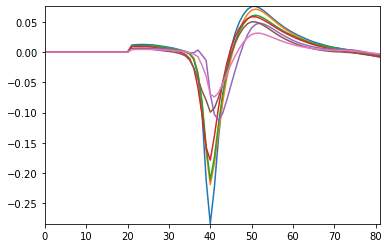

In [38]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

### Visualize a bout together with the neural traces

In [39]:
plt.rcParams['lines.linewidth'] = 0.1

In [40]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [41]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [42]:
ap_sf = all_syn_dict['ap_0']['s_f']

### one example of bout onset

In [43]:
## call the HVC/RA sites
ra_chans = range(76, 162)

clu_df['nucleus'] = np.nan
#clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'
#clu_df.loc[clu_df['main_chan'].isin(neur_chans), 'nucleus'] = 'ncm'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

In [44]:
neur_chans = ra_chans

In [45]:
mot_idx = 5

mot_start_wav = bout_dict['start_sample_wav'][mot_idx]
mot_start_ap = bout_dict['start_sample_ap_0'][mot_idx]

pre_sec = -5
post_sec = 25 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-46-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


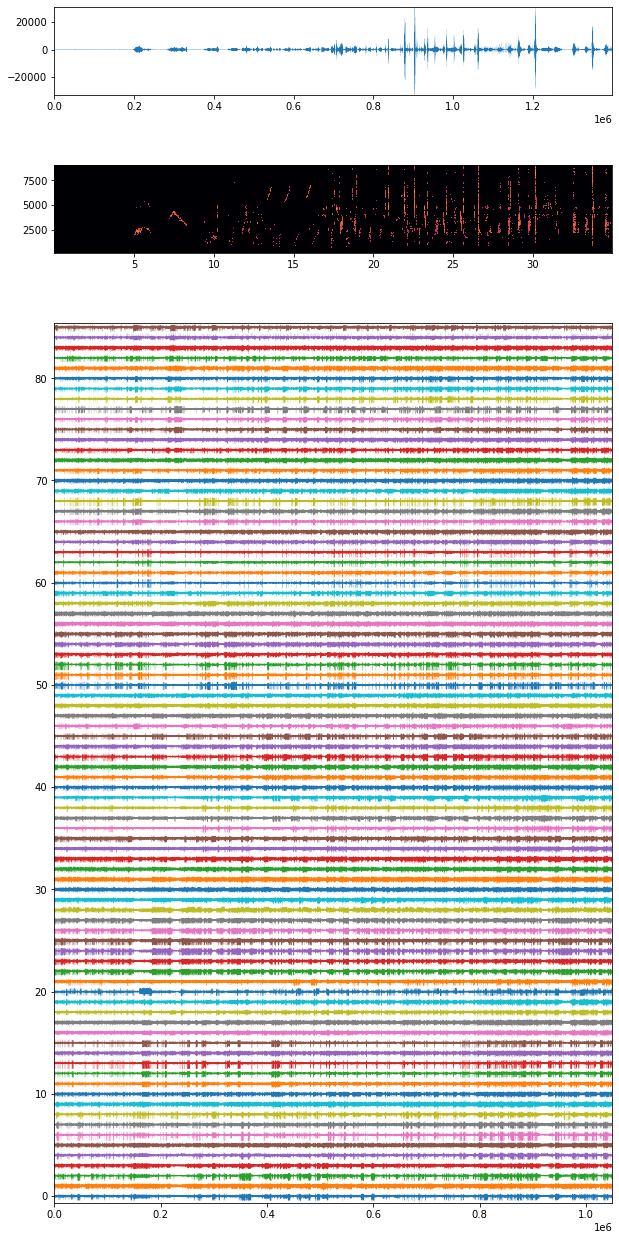

In [46]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [47]:
## get the actural raster for some clusters
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

t_pre = - 5
t_post = 5

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = mot_idx
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)
    

spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap , end_ap)


#rast_arr = ks.get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [48]:
clu_list.size

103

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


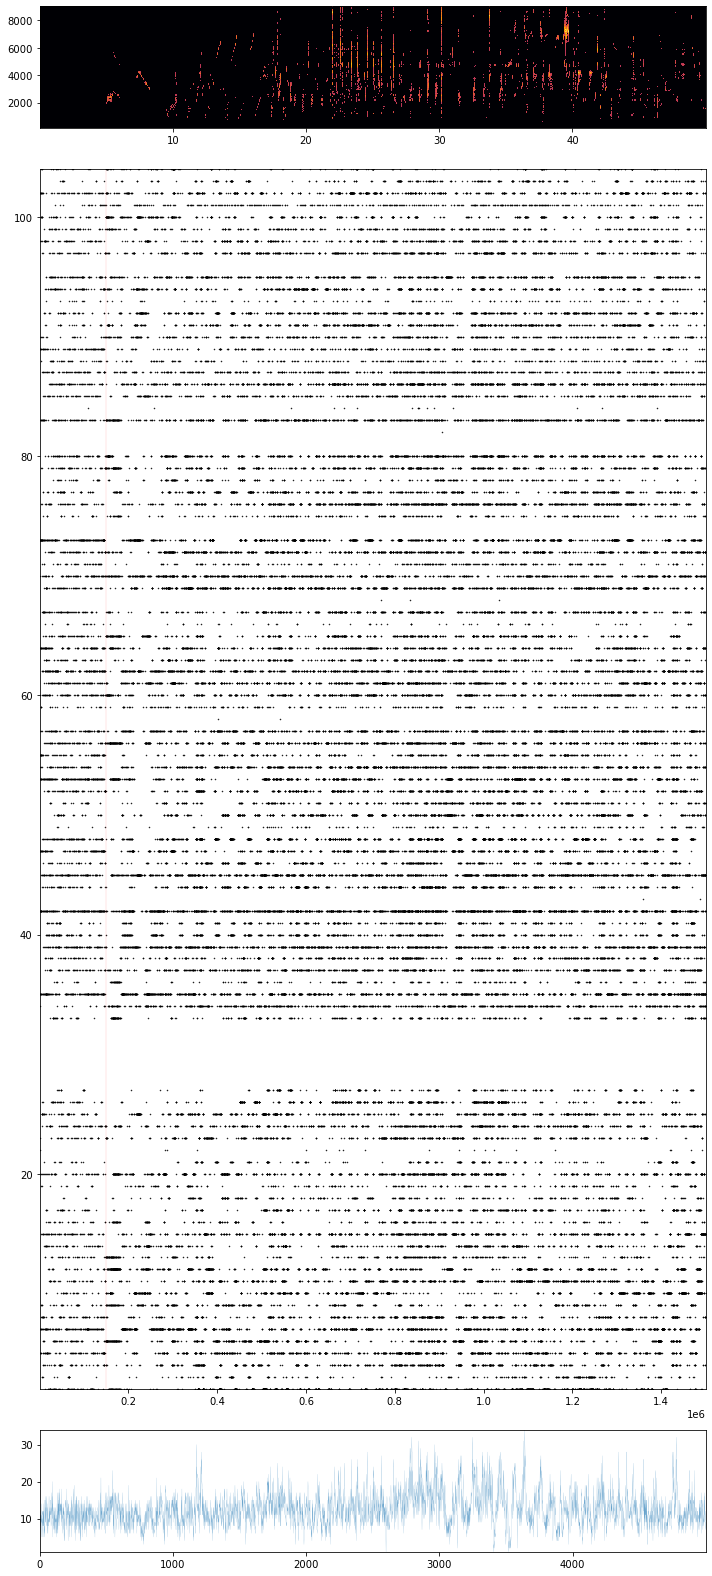

In [49]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 5
t_post = 45

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = mot_idx
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = ks.get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [50]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
#fig.savefig(fig_path+'.eps')

### save cluster and cluster metadata

In [51]:
#clu_df['nucleus'] = np.nan
#clu_df.loc[clu_df['main_chan'].isin(neur_chans), 'nucleus'] = 'ncm'

sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])
os.makedirs(sort_folder, mode=0o777, exist_ok=True)

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df.to_pickle(spk_df_path)

### Now done this, this notebooks has generated:

- Spike sorted data:
    (with quality of sort (be auto or manually in 'MSlabel/KSlabel'))
    clu_df.pickle and spk_df.pickle in 
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/sort_id
    
- behavior data, synchronized to the ap_0 channel:
    bout_pd_ap0.pkl and bout_dict_ap0.pkl
    /mnt/sphere/speech_bci/derived_data/bird/sess/sglx/epoch/
    

# now with the pressure

In [52]:
exp_struct['files']['wav_mic']

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-07-16/sglx/1426_g0/wav_mic.wav'

In [53]:
adc_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_adc.wav')
pre_chan = 0 # chans extracted in preprocessing to the adc wav were ['pressure']

s_f_wav, pre_stream = wu.read_wav_chan(adc_file_name, chan_id=pre_chan)

In [54]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'end_sample_ap_0'])

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


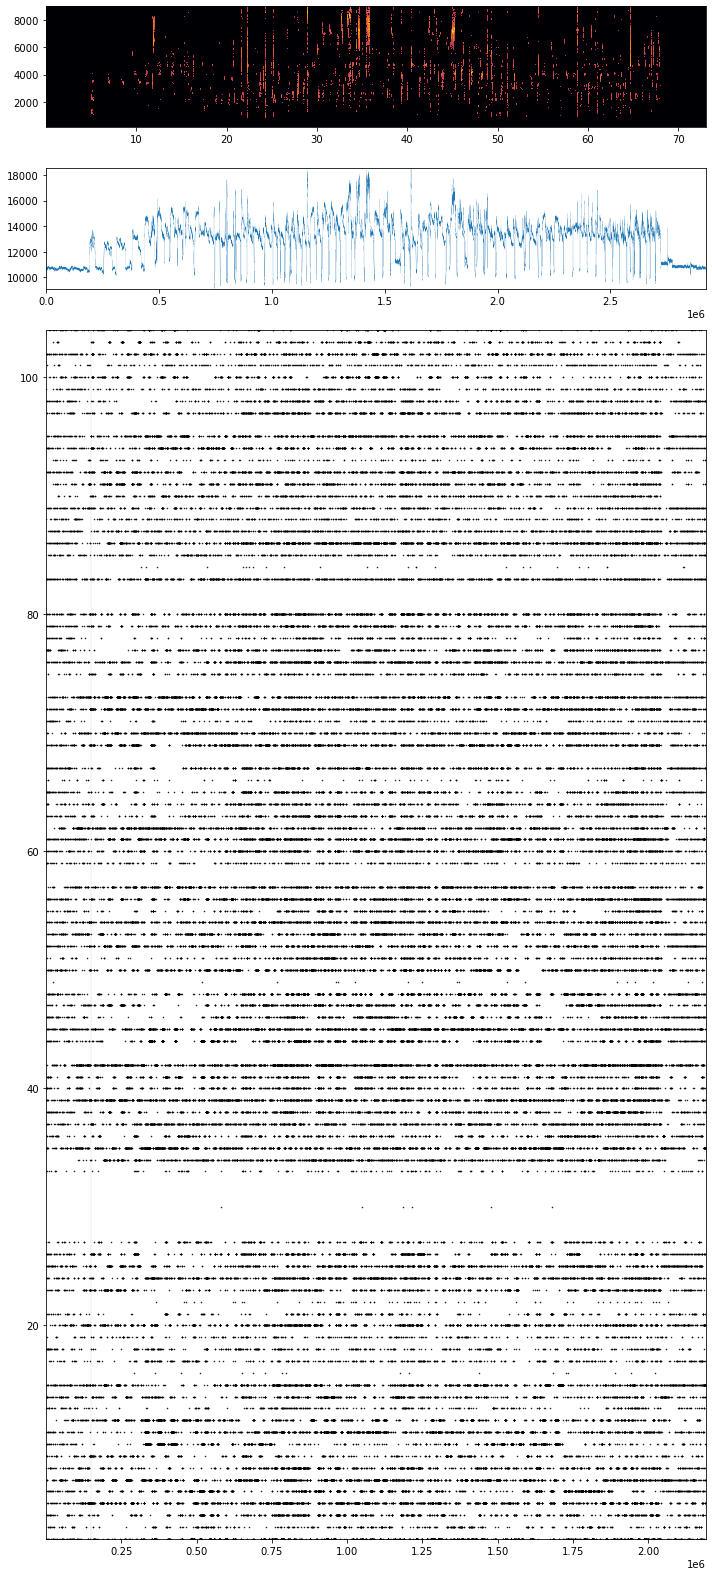

In [55]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['group']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = -5
t_post = 5
t_shift = 0.15 # a time shift for the spike array

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)
t_shift_samp = int(t_shift * s_f_ap)

##Pick a bout
bout_idx = 0
t_post += bout_dict['len_ms'][bout_idx] * 0.001

start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = ks.get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
# a shifted spike array
spk_arr_shift = ks.get_window_spikes(spk_df, clu_list, int(start_ap) + t_shift_samp, 
                                  int(end_ap) + t_shift_samp)

mic_arr = mic_stream[start_wav: end_wav]
pre_arr = pre_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax[1].plot(pre_arr.flatten());
pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[2])



plt.tight_layout()

In [56]:
### GPFA/PCA

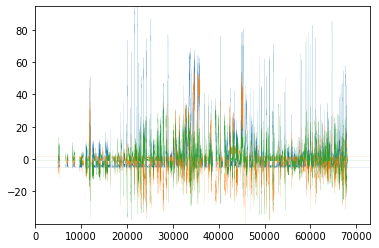

In [57]:
###PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')
sxx_pc = pca.fit_transform(np.log(sxx.T))
plt.plot(sxx_pc)

In [58]:
import neo

def spike_trains_from_spk_arr(spk_arr, s_f=30000):
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

    
bout_spk_trains = spike_trains_from_spk_arr(spk_arr)
bout_spk_trains_shift = spike_trains_from_spk_arr(spk_arr_shift)

spk_trains_list = [bout_spk_trains, bout_spk_trains_shift]

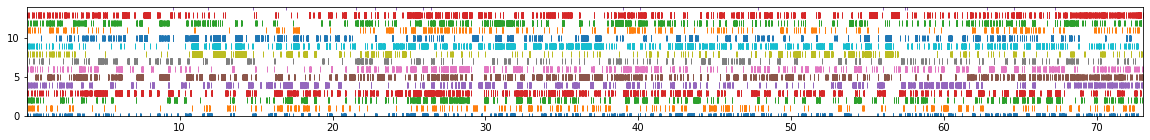

In [59]:
fig, ax = plt.subplots(figsize=(20, 2))

for i, spiketrain in enumerate(bout_spk_trains_shift[:15]):
    ax.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

In [60]:
import quantities as pq
from elephant.gpfa import GPFA
import viziphant as vp

# specify fitting parameters
bin_size = 15 * pq.ms

latent_dimensionality = 6

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [61]:
gpfa_2dim.fit(spk_trains_list)
print(gpfa_2dim.params_estimated.keys())

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [64]:
trajectories_list = gpfa_2dim.transform(spk_trains_list)

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


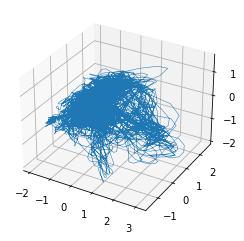

In [65]:
### plot a single one
i_bout = 15
single_trial_trajectory = trajectories_list[0]
shifted_trial_trajectory = trajectories_list[1]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], '-', lw=0.5)

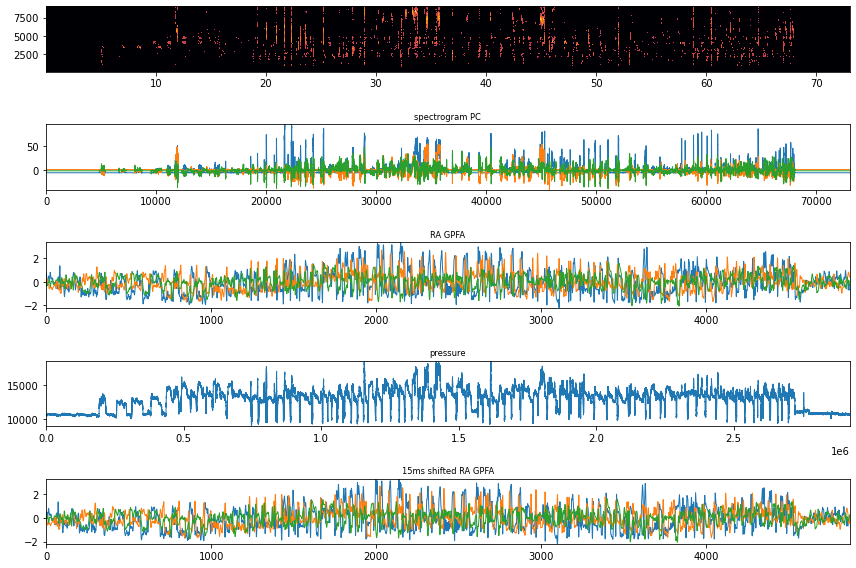

In [66]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8))

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

ax[1].set_title('spectrogram PC')
ax[1].plot(sxx_pc, lw=1);

ax[2].set_title('RA GPFA')
ax[2].plot(single_trial_trajectory[:3].T, lw=1);

ax[3].set_title('pressure')
ax[3].plot(pre_arr, lw=1);

ax[4].set_title('15ms shifted RA GPFA')
ax[4].plot(shifted_trial_trajectory[:3].T, lw=1);
plt.tight_layout()